# [Deep Learning with PyTorch Step-by-Step: A Beginner's Guide](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/Chapter02.1.ipynb)

## Chapter 2: Simple Linear Regression

In [9]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime


In [10]:
plt.style.use('fivethirtyeight')

def figure1(x, y):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.scatter(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim([0, 3.1])
    ax.set_title('Generated Data - Full Dataset')
    fig.tight_layout()
    return fig

## StepByStep Class

In [11]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.now().strftime('%Y%m%d%H%M%S')
        #self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4,
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename, weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


## Data Generaton

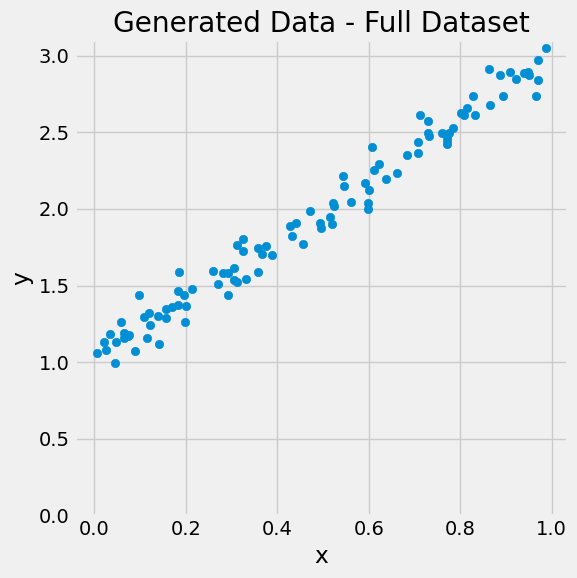

In [12]:
true_b = 1
true_w = 2
N = 100

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

fig = figure1(x, y)

## Data Preparation


In [13]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

## Model Configuration

In [14]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


## Model Training

In [15]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

print(sbs.model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [16]:
sbs.train(n_epochs=200)

print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict({'0.weight': tensor([[1.9416]]), '0.bias': tensor([1.0235])})
200


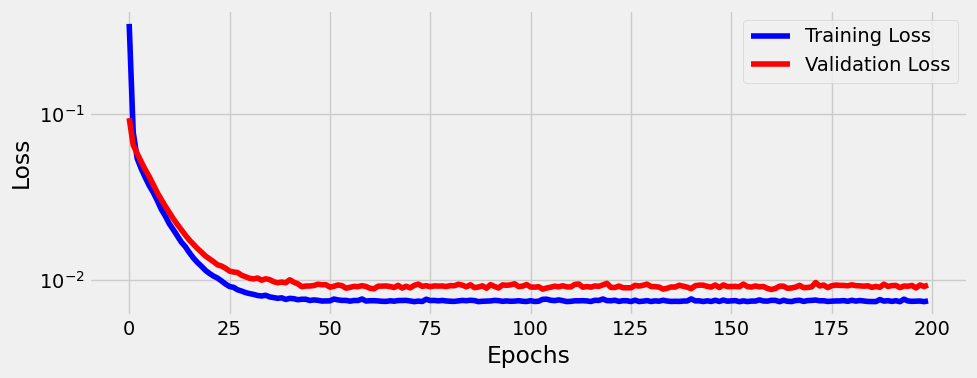

In [17]:
fig = sbs.plot_losses()

## Making Predictions

In [18]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [19]:
predictions = sbs.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825974]], dtype=float32)

## Checkpointing

In [20]:
sbs.save_checkpoint('model_checkpoint.pth')

## Resuming Training

In [21]:
# reset model
model = nn.Sequential(nn.Linear(1, 1))
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

print(model.state_dict())

OrderedDict({'0.weight': tensor([[-0.5052]]), '0.bias': tensor([-0.3177])})


In [22]:
new_sbs = StepByStep(model, loss_fn, optimizer)
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9416]]), '0.bias': tensor([1.0235])})


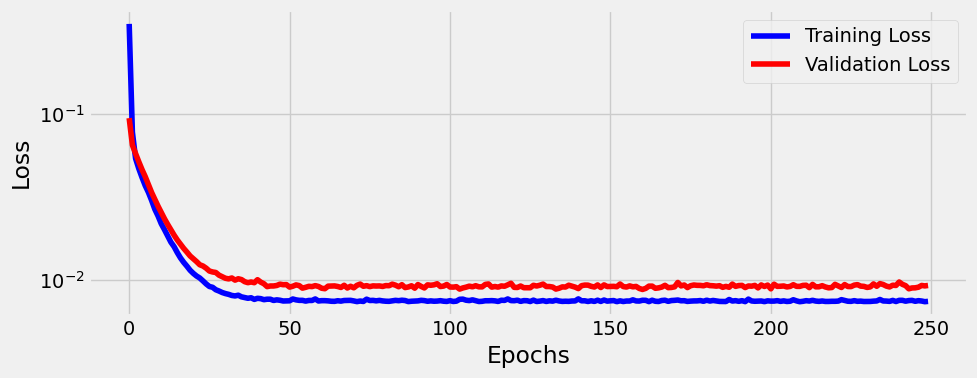

In [23]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

fig = new_sbs.plot_losses()


In [24]:
print(sbs.model.state_dict())

OrderedDict({'0.weight': tensor([[1.9416]]), '0.bias': tensor([1.0235])})
